In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pybaseball import team_game_logs
from pybaseball import team_ids
from pybaseball import team_batting

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


import statsmodels.api as sm
import statsmodels.tools.eval_measures as sme

import import_ipynb
import functions as func

pd.set_option('display.max_columns', None)

importing Jupyter notebook from functions.ipynb


In [2]:
raw_data = pd.read_csv('data/PitchData_21.csv')
raw_data.drop(columns=raw_data.columns[0], inplace=True)

In [3]:
data = raw_data.copy()
# keep regular season games
data = data[data['game_type']=='R'].copy()

In [4]:
# create dummies for pitch event
dummies = pd.get_dummies(data['description'])
dummies.rename(columns=lambda x: x+'_dummy', inplace=True)
data = pd.concat((data, dummies), axis=1)

Statcast Stats Explained: https://baseballsavant.mlb.com/csv-docs

Strike Zone Size: https://baseballsavant.mlb.com/visuals/profile?pitch_type=&batter=&pitcher=&balls=&strikes=&year=2020&min_strikes=0&bucket_size=0.5&chart_type=swings&player_id=&position=&player_name=

Shadow Zone: https://twitter.com/tangotiger/status/1066511998433796097?lang=en

In [5]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_pitchout_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy
10786,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,NaN,NaN,518595.0,NaN,NaN,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148.0,0.000,-0.073,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10787,SL,2021-10-03,80.6,1.60,6.64,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,4.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,1,2021,-0.77,0.48,-0.71,2.62,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,3.32,1.51,108.0,75.3,75.0,81.2,2254.0,6.4,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,Slider,5,0,0,5,0,5,0,5,Infield shift,Strategic,315.0,0.000,-0.027,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10788,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,5.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,0,2021,-0.65,-0.51,-0.04,2.46,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,3.32,1.51,157.0,83.5,65.0,75.2,1940.0,6.2,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,Curveball,5,0,0,5,0,5,0,5,Infield shift,Standard,328.0,0.000,-0.020,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10789,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,NaN,ball,NaN,NaN,NaN,NaN,12.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,NaN,NaN,0,0,2021,-0.69,-0.69,2.10,3.89,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,2.375830,-109.205830,2.277617,-5.902656,19.427562,-38.284747,3.31,1.48,NaN,NaN,NaN,74.5,2017.0,5.9,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330.0,0.000,0.016,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10790,FF,2021-10-03,91.2,1.49,6.66,"Smith, Will",607043,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Brandon Nimmo grounds out, second baseman Ozzi...",R,L,L,ATL,NYM,X,4.0,ground_ball,1,0,2021,0.63,1.28,-0.31,2.80,NaN,NaN,NaN,1,9,Top,144.83,145.72,NaN,NaN,518595.0,NaN,NaN,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,3.49,1.60,9.0,93.3,-18.0,90.9

In [6]:
data.shape

(709851, 106)

In [7]:
# drop rows if missingn plate_x
data = data[data['plate_x'].notna()].copy()
data.shape

(709483, 106)

In [8]:
data = data.reset_index(drop=True).rename_axis('pitch_index').reset_index().copy()

# label team abbrviation

In [9]:
data.loc[data['inning_topbot']=='Top', 'batting_team'] = data[data['inning_topbot']=='Top']['away_team']
data.loc[data['inning_topbot']=='Bot', 'batting_team'] = data[data['inning_topbot']=='Bot']['home_team']
data.iloc[[13630]][['home_team', 'away_team', 'inning_topbot', 'batting_team']]

,home_team,away_team,inning_topbot,batting_team
13630,ATL,PHI,Top,PHI


# define strike zone

In [10]:
# regular X broundaries

szLeftB = -10/12
szRightB = 10/12

In [11]:
# regular Z boundaries
data['szTop'] = data['sz_top'] + 0.12
data['szBot'] = data['sz_bot'] - 0.12

In [12]:
# create Z middle point
data['szMid'] = round((data['sz_top'] - data['sz_bot'])/2+data['sz_bot'], 2)

# define shadow zone

In [13]:
shadowLeft = -6.7/12
shadowRight = 6.7/12
data['shadowTop'] = data['szMid'] + 8/12
data['shadowBot'] = data['szMid'] - 8/12

In [14]:
shadowLeft

-0.5583333333333333

In [15]:
data['shadowTop'].mean()

3.1502100214841815

In [16]:
data['shadowBot'].mean()

1.8168766881402614

In [17]:
data['sz_bot'].mean()

1.5738712555522263

In [18]:
data['szMid'].mean()

2.4835433548075736

# label pitches based on in and out of SZ/shadow

In [19]:
# create boolean for pitches in the strike zone
x_boo = data['plate_x'].between(szLeftB, szRightB, inclusive='neither').copy()
y_boo = data['plate_z'].between(data['szBot'], data['szTop'], inclusive='neither').copy()
# boolean for shadow zone
x_boo_shadow = data['plate_x'].between(shadowLeft, shadowRight, inclusive='neither').copy()
y_boo_shadow = data['plate_z'].between(data['shadowBot'], data['shadowTop'], inclusive='neither').copy()

In [20]:
(x_boo&y_boo).sum()

347778

In [21]:
(x_boo_shadow&y_boo_shadow).sum()

181905

In [22]:
data.loc[(x_boo & y_boo), 'sz_inOut'] = 'in'
data.loc[~(x_boo & y_boo), 'sz_inOut'] = 'out'
data.loc[(x_boo_shadow & y_boo_shadow), 'shadow_inOut'] = 'in'
data.loc[~(x_boo_shadow & y_boo_shadow), 'shadow_inOut'] = 'out'

# label called strike

In [23]:
# total called strike
data.loc[data['description']=='called_strike', 'called_strike'] = 1
data.loc[~(data['description']=='called_strike'), 'called_strike'] = 0

In [24]:
# called strike in shadow
data.loc[(data['description']=='called_strike')&(data['shadow_inOut']=='out'), 'called_strike_shadow'] = 1
data.loc[(data['description']!='called_strike')&(data['shadow_inOut']=='out'), 'called_strike_shadow'] = 0


# drop unwanted columns

In [25]:
col_keep = ['game_date', 'home_team', 'away_team', 'game_pk', 'batting_team', 'ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy', 'called_strike', 'called_strike_shadow']
data_lean = data[col_keep].copy()
data_lean.head()

,game_date,home_team,away_team,game_pk,batting_team,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,called_strike,called_strike_shadow
0,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0
1,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0
2,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,NaN
3,2021-10-03,ATL,NYM,632254,NYM,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
4,2021-10-03,ATL,NYM,632254,NYM,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,NaN


# group data by game

In [26]:
data_grouped = data_lean.groupby(['game_pk', 'batting_team']).agg({'game_date':max, 'home_team':max, 'away_team':max,
                              'ball_dummy':sum, 'blocked_ball_dummy':sum, 'bunt_foul_tip_dummy':sum, 
                              'called_strike_dummy':sum, 'foul_dummy':sum, 'foul_bunt_dummy':sum, 
                              'foul_tip_dummy':sum, 'hit_by_pitch_dummy':sum, 'hit_into_play_dummy':sum,
                              'missed_bunt_dummy':sum, 'pitchout_dummy':sum, 'swinging_strike_dummy': sum,
                              'swinging_strike_blocked_dummy':sum, 'called_strike':sum, 'called_strike_shadow':sum}, inplace=True)
data_grouped.reset_index(inplace=True)

In [27]:
data_grouped['called_strike_pct'] = data_grouped['called_strike_shadow'] / data_grouped['called_strike']

In [28]:
data_grouped['called_strike_pct']

0       0.520000
1       0.521739
2       0.562500
3       0.647059
4       0.550000
          ...   
4851    0.466667
4852    0.611111
4853    0.473684
4854    0.722222
4855    0.533333
Name: called_strike_pct, Length: 4856, dtype: float64

<AxesSubplot:xlabel='called_strike_pct', ylabel='Count'>

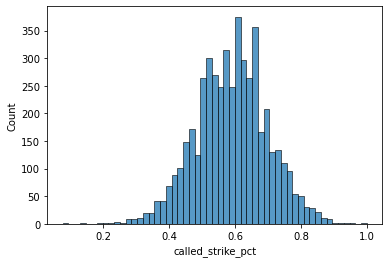

In [29]:
sns.histplot(data=data_grouped, x='called_strike_pct')

# read batting logs file

In [30]:
raw_data_battingLogs = pd.read_csv('data/battingLogs_21.csv')
raw_data_battingLogs.drop(columns=[raw_data_battingLogs.columns[0]], inplace=True)

In [31]:
battingLogs = raw_data_battingLogs.copy()

# create date_time for battingLogs

In [32]:
for index, row in battingLogs.iterrows():
    battingLogs.at[index, 'month'] = row['Date'].split(" ")[0]
    battingLogs.at[index, 'day'] = row['Date'].split(" ")[1]

In [33]:
# convert month abb into number
month_list = battingLogs['month'].unique()
month_dict = {'Apr':'4', 'May':'5', 'Jun':'6', 'Jul':'7', 'Aug':'8', 'Sep':'9', 'Oct':'10'}

In [34]:
for month in month_list:
    for index, row in battingLogs.iterrows():
        if battingLogs.at[index, 'month'] == month:
            battingLogs.at[index, 'month'] = month_dict[month]

In [35]:
battingLogs['date_time'] = "2021-" + battingLogs['month'] + "-" + battingLogs['day']

In [36]:
# drop unwanted date info
battingLogs.drop(columns=['Date', 'month', 'day'], inplace=True)

In [37]:
battingLogs.head()

,Game,Home,Opp,Rslt,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,LOB,NumPlayers,Thr,OppStart,Team,date_time
0,1,True,BOS,"W,3-0",36,34,3,9,2,0,0,3,2,0,7,0,0,0,0,2,0,0,0.265,0.306,0.324,0.629,6,10,R,N.Eovaldi(59),BAL,2021-4-2
1,2,True,BOS,"W,4-2",36,34,4,8,1,0,0,4,1,0,11,0,0,1,0,0,0,0,0.250,0.278,0.294,0.572,5,10,R,T.Houck(52),BAL,2021-4-3
2,3,True,BOS,"W,11-3",52,44,11,17,6,0,0,10,8,0,15,0,0,0,0,0,0,0,0.304,0.363,0.384,0.747,14,10,R,G.Richards(18),BAL,2021-4-4
3,4,True,NYY,"L,0-7",33,31,0,4,0,0,0,0,2,0,13,0,0,0,0,0,1,0,0.266,0.325,0.329,0.654,6,9,L,J.Montgomery(71),BAL,2021-4-5
4,5,True,NYY,"L,2-7",34,34,2,7,2,0,1,2,0,0,14,0,0,0,0,0,1,0,0.254,0.304,0.333,0.637,5,9,R,G.Cole(82),BAL,2021-4-6


In [38]:
battingLogs.shape

(4858, 32)

# convert battingLogs team name into mlb style

In [39]:
current_list = battingLogs['Team'].unique()
battingLogs['Team'].unique()

array(['BAL', 'BOS', 'CHW', 'CLE', 'DET', 'HOU', 'KCR', 'LAA', 'MIN',
       'NYY', 'OAK', 'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC',
       'CIN', 'COL', 'LAD', 'MIA', 'MIL', 'NYM', 'PHI', 'PIT', 'SDP',
       'SFG', 'STL', 'WSN'], dtype=object)

In [40]:
target_list = data_grouped['home_team'].unique()
data_grouped['home_team'].unique()

array(['SF', 'CWS', 'NYM', 'MIN', 'LAD', 'TEX', 'MIL', 'PIT', 'STL', 'KC',
       'BAL', 'HOU', 'TOR', 'TB', 'ARI', 'ATL', 'CLE', 'WSH', 'SEA',
       'NYY', 'MIA', 'COL', 'OAK', 'SD', 'DET', 'LAA', 'PHI', 'CHC',
       'CIN', 'BOS'], dtype=object)

In [41]:
teamName = {}
for name in current_list:
    if name in target_list:
        teamName[name] = name
    else:
        print(name)

CHW
KCR
TBR
SDP
SFG
WSN


In [42]:
teamName['CHW'] = 'CWS'
teamName['KCR'] = 'KC'
teamName['TBR'] = 'TB'
teamName['SDP'] = 'SD'
teamName['SFG'] = 'SF'
teamName['WSN'] = 'WSH'

In [43]:
for index, row in battingLogs.iterrows():
    battingLogs.at[index, 'Opp'] = teamName[row['Opp']]
    battingLogs.at[index, 'Team'] = teamName[row['Team']]

In [44]:
# check result
battingLogs['Opp'].unique()

array(['BOS', 'NYY', 'SEA', 'TEX', 'MIA', 'OAK', 'NYM', 'TB', 'WSH',
       'MIN', 'CWS', 'CLE', 'TOR', 'HOU', 'LAA', 'KC', 'DET', 'ATL',
       'PHI', 'BAL', 'CIN', 'STL', 'PIT', 'MIL', 'CHC', 'COL', 'LAD',
       'SD', 'SF', 'ARI'], dtype=object)

# add date_time to both datasets

In [45]:
battingLogs['date_time'] = pd.to_datetime(battingLogs['date_time'])

In [46]:
data_grouped['date_time'] = pd.to_datetime(data_grouped['game_date'])

# delete all double header games

In [47]:
# get index of all double headers
dup = battingLogs.duplicated(subset=['Team', 'date_time'], keep=False)
print(f"Total of {dup.sum()} double headers")

Total of 236 double headers


In [48]:
idx = battingLogs[battingLogs.duplicated(subset=['Team', 'date_time'], keep=False)].index

In [49]:
# drop double headers
battingLogs_dropped = battingLogs.drop(index=idx).copy()
battingLogs_dropped.reset_index(drop=True, inplace=True)

# Merge two datasets

In [50]:
data_merged = battingLogs_dropped.merge(data_grouped, left_on=['Team', 'date_time'], 
                                right_on=['batting_team', 'date_time'], how='inner')

In [51]:
data_merged.head()

,Game,Home,Opp,Rslt,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,LOB,NumPlayers,Thr,OppStart,Team,date_time,game_pk,batting_team,game_date,home_team,away_team,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,called_strike,called_strike_shadow,called_strike_pct
0,1,True,BOS,"W,3-0",36,34,3,9,2,0,0,3,2,0,7,0,0,0,0,2,0,0,0.265,0.306,0.324,0.629,6,10,R,N.Eovaldi(59),BAL,2021-04-02,634627,BAL,2021-04-02,BOS,BAL,59,6,0,21,29,1,0,0,27,0,0,21,0,21.0,11.0,0.523810
1,2,True,BOS,"W,4-2",36,34,4,8,1,0,0,4,1,0,11,0,0,1,0,0,0,0,0.250,0.278,0.294,0.572,5,10,R,T.Houck(52),BAL,2021-04-03,634577,BAL,2021-04-03,BOS,BAL,49,1,0,24,17,0,4,0,24,0,0,15,2,24.0,16.0,0.666667
2,3,True,BOS,"W,11-3",52,44,11,17,6,0,0,10,8,0,15,0,0,0,0,0,0,0,0.304,0.363,0.384,0.747,14,10,R,G.Richards(18),BAL,2021-04-04,634610,BAL,2021-04-04,BOS,BAL,78,10,0,33,37,0,3,0,29,0,0,25,2,33.0,23.0,0.696970
3,4,True,NYY,"L,0-7",33,31,0,4,0,0,0,0,2,0,13,0,0,0,0,0,1,0,0.266,0.325,0.329,0.654,6,9,L,J.Montgomery(71),BAL,2021-04-05,634587,BAL,2021-04-05,NYY,BAL,31,3,0,16,23,0,5,0,18,0,0,22,2,16.0,10.0,0.625000
4,5,True,NYY,"L,2-7",34,34,2,7,2,0,1,2,0,0,14,0,0,0,0,0,1,0,0.254,0.304,0.333,0.637,5,9,R,G.Cole(82),BAL,2021-04-06,634599,BAL,2021-04-06,NYY,BAL,32,5,0,23,19,1,5,0,20,0,0,22,4,23.0,10.0,0.434783


# format and drop unwanted columns

In [52]:
col_keep = ['game_pk', 'date_time', 'batting_team', 'Opp', 'called_strike_pct', 'ball_dummy', 'blocked_ball_dummy',
          'bunt_foul_tip_dummy', 'called_strike_dummy', 'foul_dummy', 'foul_bunt_dummy', 'foul_tip_dummy',
          'hit_by_pitch_dummy', 'hit_into_play_dummy', 'missed_bunt_dummy', 'pitchout_dummy',
          'swinging_strike_dummy', 'swinging_strike_blocked_dummy', 'PA', 'BB', 'HBP', 'SO']

In [53]:
data_final = data_merged[col_keep].copy()

In [54]:
data_final['action'] = data_final['PA'] - data_final['BB'] - data_final['HBP'] - data_final['SO']

In [55]:
data_final.head()

,game_pk,date_time,batting_team,Opp,called_strike_pct,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,PA,BB,HBP,SO,action
0,634627,2021-04-02,BAL,BOS,0.523810,59,6,0,21,29,1,0,0,27,0,0,21,0,36,2,0,7,27
1,634577,2021-04-03,BAL,BOS,0.666667,49,1,0,24,17,0,4,0,24,0,0,15,2,36,1,0,11,24
2,634610,2021-04-04,BAL,BOS,0.696970,78,10,0,33,37,0,3,0,29,0,0,25,2,52,8,0,15,29
3,634587,2021-04-05,BAL,NYY,0.625000,31,3,0,16,23,0,5,0,18,0,0,22,2,33,2,0,13,18
4,634599,2021-04-06,BAL,NYY,0.434783,32,5,0,23,19,1,5,0,20,0,0,22,4,34,0,0,14,20


# check corr map

In [56]:
var_corr = ['action','PA', 'BB', 'HBP', 'SO','called_strike_pct']
corr_df = data_final[var_corr]
corrmat = corr_df.corr()

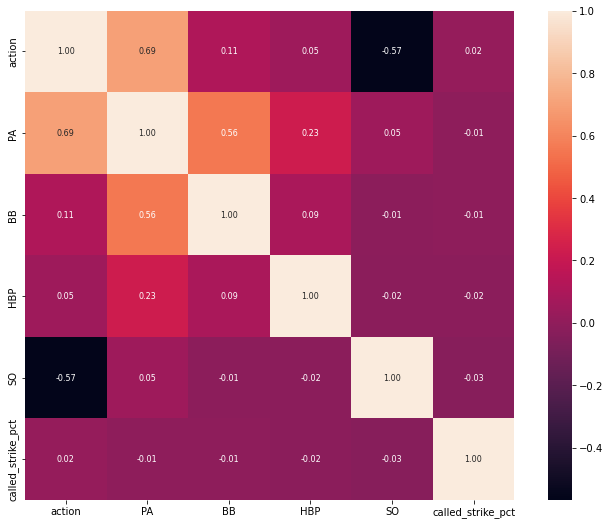

In [57]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, annot=True, fmt='.2f', annot_kws={'size': 8});

In [58]:
train_df, test_df = train_test_split(data_final, test_size=0.2, random_state=0, shuffle=True)

In [65]:
predictors = ['called_strike_pct']
response = 'PA'

results = func.fit_ols(predictors, response, train_df)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     PA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.007
Date:                Wed, 16 Mar 2022   Prob (F-statistic):              0.316
Time:                        11:53:58   Log-Likelihood:                -10935.
No. Observations:                3696   AIC:                         2.187e+04
Df Residuals:                    3694   BIC:                         2.189e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                38.2953      0.42

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# check

In [60]:
data_final.sort_values(['game_pk', 'batting_team'], ascending=True)

,game_pk,date_time,batting_team,Opp,called_strike_pct,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy,PA,BB,HBP,SO,action
2947,632169,2021-04-10,COL,SF,0.520000,53,3,0,25,36,0,5,0,22,0,0,16,0,36,3,0,11,22
4167,632169,2021-04-10,SF,COL,0.521739,46,9,0,23,31,0,1,0,23,0,0,11,0,34,7,0,4,23
314,632170,2021-04-11,CWS,KC,0.562500,70,9,0,32,28,2,0,0,27,0,0,15,1,44,9,0,8,27
919,632170,2021-04-11,KC,CWS,0.647059,64,4,0,17,37,0,0,0,21,0,0,26,3,40,5,0,14,21
2948,632188,2021-04-11,COL,SF,0.550000,46,6,0,20,27,0,1,0,25,0,0,21,0,39,4,0,10,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089,634653,2021-04-02,LAD,COL,0.576923,59,4,0,26,25,1,0,1,37,1,0,14,1,47,2,1,7,37
2780,634654,2021-04-03,CIN,STL,0.692308,51,5,0,26,18,1,1,3,27,1,0,19,0,41,3,3,8,27
4319,634654,2021-04-03,STL,CIN,0.466667,68,3,0,30,25,0,4,0,22,0,0,18,0,40,5,0,13,22
306,634655,2021-04-01,CWS,LAA,0.611111,41,1,0,18,16,1,0,0,23,0,0,23,2,35,2,0,10,23


<AxesSubplot:xlabel='called_strike_pct', ylabel='PA'>

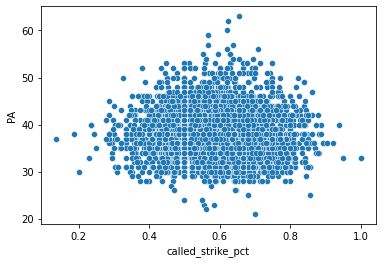

In [62]:
sns.scatterplot(data=data_final, x='called_strike_pct', y='PA')

# plot strike zone

In [ ]:
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="size", palette="deep")


<AxesSubplot:xlabel='plate_x', ylabel='plate_z'>

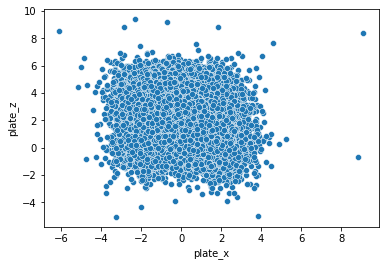

In [69]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x='plate_x', y='plate_z')